# Environment Settings

In [ ]:
pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 3.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import glob
import folium
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Preprocess

In [ ]:
def coordinates_convert(data):
  # Extracting latitude and longitude from the 'coordinates' column and adding them as separate columns
  data['latitude'] = data['coordinates'].apply(lambda x: eval(x)['latitude'])
  data['longitude'] = data['coordinates'].apply(lambda x: eval(x)['longitude'])

  # Converting to float (even though they should already be floats)
  data['latitude'] = data['latitude'].astype(float)
  data['longitude'] = data['longitude'].astype(float)

  # Dropping the original 'coordinates' column as it's no longer needed
  data = data.drop(columns=['coordinates'])
  return data

In [ ]:
def process():
    # Dictionary to store the processed DataFrames
    city_data = {}

    # List of city filenames and corresponding keys
    city_files = {
        'houston': '5332_houston.csv',
        'chicago': '5259_chicago.csv',
        'la': '9348_la.csv',
        'nyc': '16056_nyc.csv'
    }
    # Process each city file
    for city, file in city_files.items():
        df = pd.read_csv(file)
        df = df.drop(columns=['Unnamed: 0', 'image_url', 'is_closed', 'attributes'])
        # Apply literal_eval to the 'categories' column
        df = coordinates_convert(df)
        city_data[city] = df

    return city_data

In [ ]:
city_data = process()
houston_list = city_data['houston']
chicago_list = city_data['chicago']
la_list = city_data['la']
nyc_list = city_data['nyc']

In [ ]:
city_dataframes = {
    'NYC': nyc_list,
    'LA': la_list,
    'Chicago': chicago_list,
    'Houston': houston_list
}

In [ ]:
boundaries = {
    'NYC': ['NYC_Borough.geojson','NYC_Neighborhoods.geojson'],
    'LA': ['LA_Community.geojson','LA_Neighborhoods.geojson'],
    'Chicago': ['Chicago_Neighborhoods.geojson'],
    'Houston': ['Houston_Neighborhoods.geojson']
}

# Neighborhood Maps

## Average Score

In [ ]:
def neighborhood_scores(city_dataframes, boundaries):
  for city, df in city_dataframes.items():
    for item in boundaries[city]:
      neighborhoods = gpd.read_file(item)
      restaurants = df
      restaurants_gdf = gpd.GeoDataFrame(
          restaurants,
          geometry=gpd.points_from_xy(restaurants.longitude, restaurants.latitude),
          crs="EPSG:4326"
      )
      restaurants_in_neighborhoods = gpd.sjoin(restaurants_gdf, neighborhoods, how='left', predicate='within')
      neighborhood_scores = restaurants_in_neighborhoods.groupby('NBNAME').agg({
          'rating': 'mean'
      }).reset_index()
      neighborhoods = neighborhoods.merge(neighborhood_scores, how='left', left_on='NBNAME', right_on='NBNAME')
      district = item.split('_')[1]
      fig, ax = plt.subplots(figsize=(10, 10))
      neighborhoods.boundary.plot(ax=ax, linewidth=1, color='black')
      # Generate a cubehelix colormap from seaborn
      sns.set_palette("Blues")
      neighborhoods.plot(column='rating', cmap='RdYlGn', linewidth=0.8, ax=ax, edgecolor='0.', legend=True)

      plt.title(f'Average Restaurant Scores by {district} in {city}')
      plt.show()

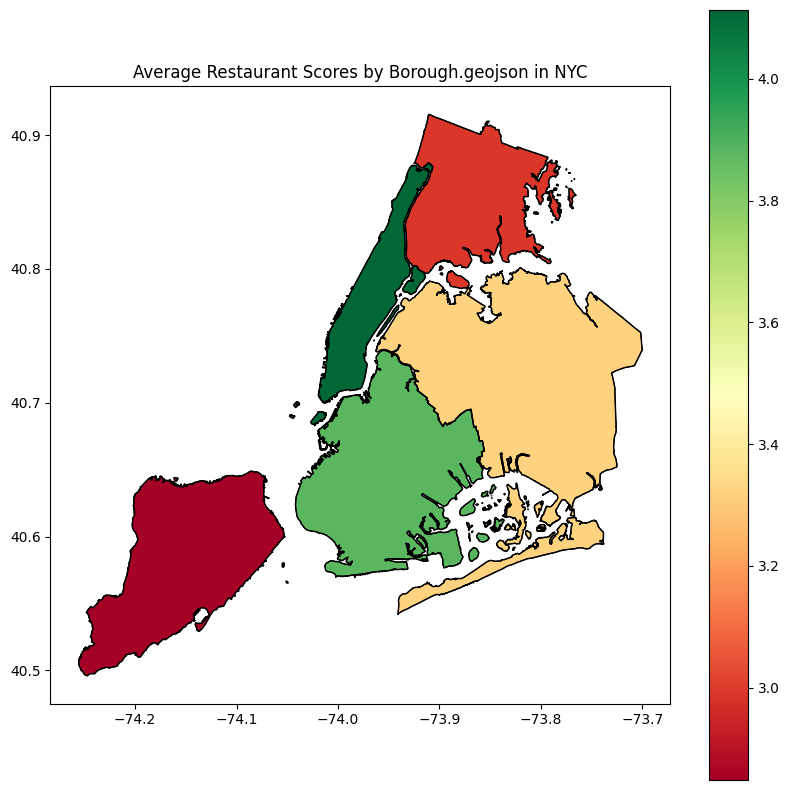

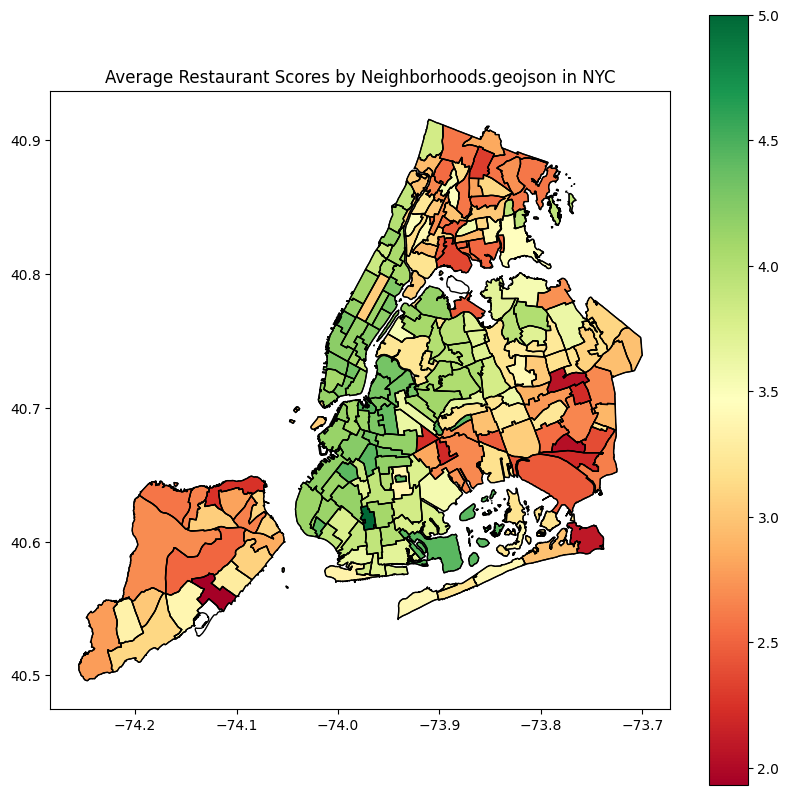

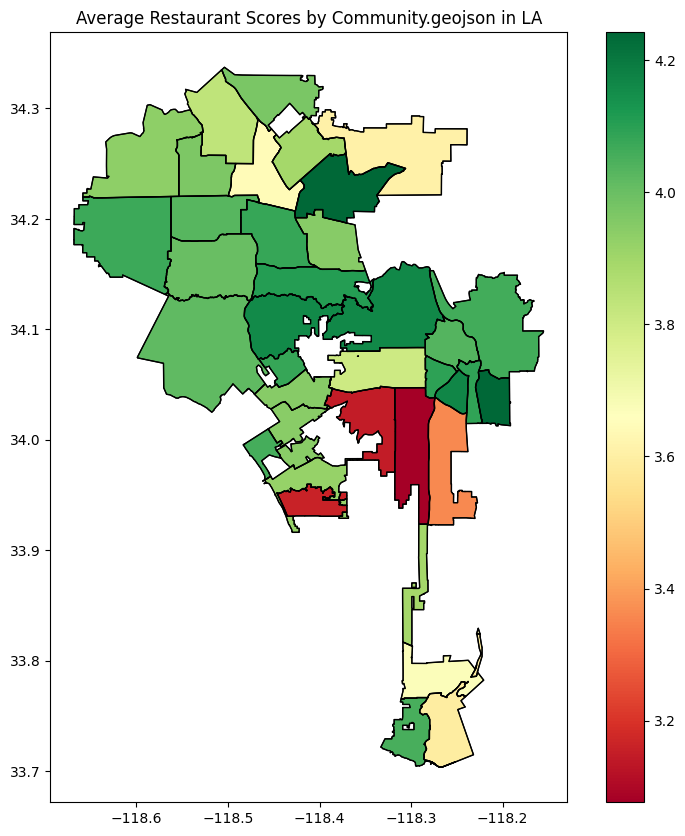

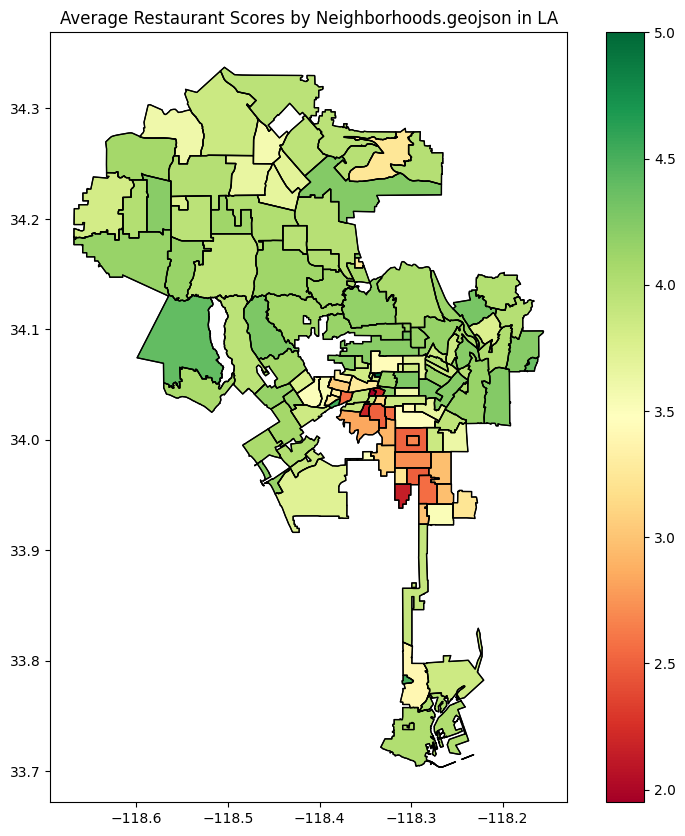

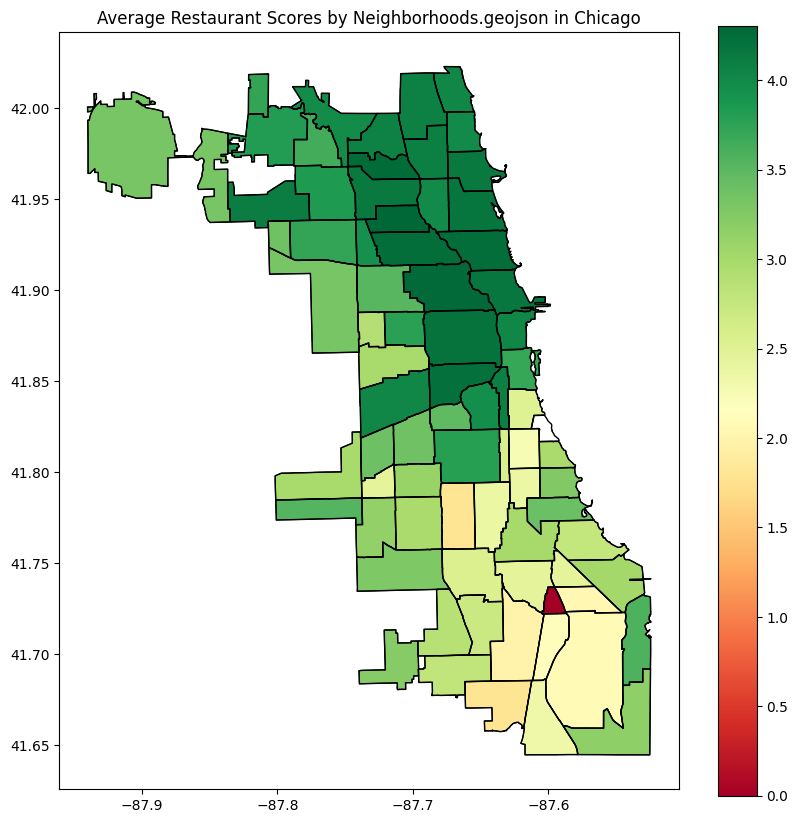

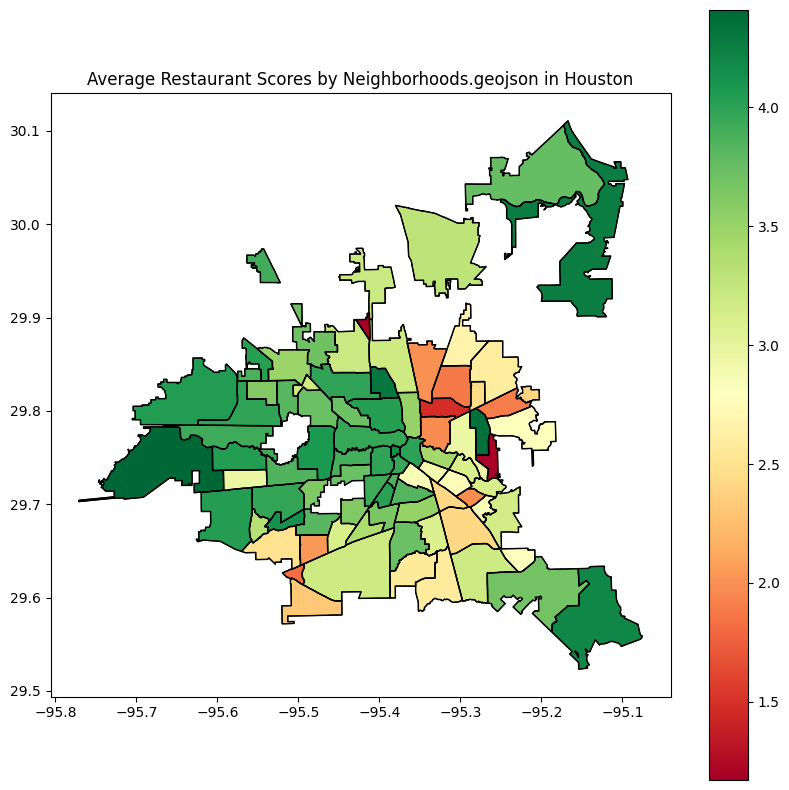

In [ ]:
neighborhood_scores(city_dataframes, boundaries)

## Density

In [ ]:
def neighborhood_restaurant_density(city_dataframes, boundaries):
  for city, df in city_dataframes.items():
    for item in boundaries[city]:
      neighborhoods = gpd.read_file(item)
      neighborhoods = neighborhoods.rename(columns={'name': 'NBNAME'})
      restaurants = df
      restaurants_gdf = gpd.GeoDataFrame(
          restaurants,
          geometry=gpd.points_from_xy(restaurants.longitude, restaurants.latitude),
          crs="EPSG:4326"
      )
      restaurants_in_neighborhoods = gpd.sjoin(restaurants_gdf, neighborhoods, how='left', predicate='within')
      neighborhood_scores = restaurants_in_neighborhoods.groupby('NBNAME').agg({'id': 'count'}).reset_index()
      neighborhoods = neighborhoods.merge(neighborhood_scores, how='left', left_on='NBNAME', right_on='NBNAME')
      district = item.split('_')[1]
      fig, ax = plt.subplots(figsize=(10, 10))
      neighborhoods.boundary.plot(ax=ax, linewidth=1, color='black')
      sns.set_palette("YlGnBu")
      neighborhoods.plot(column='id', cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor='0.', legend=True)

      plt.title(f'Restaurant Density by {district} in {city}')
      plt.show()

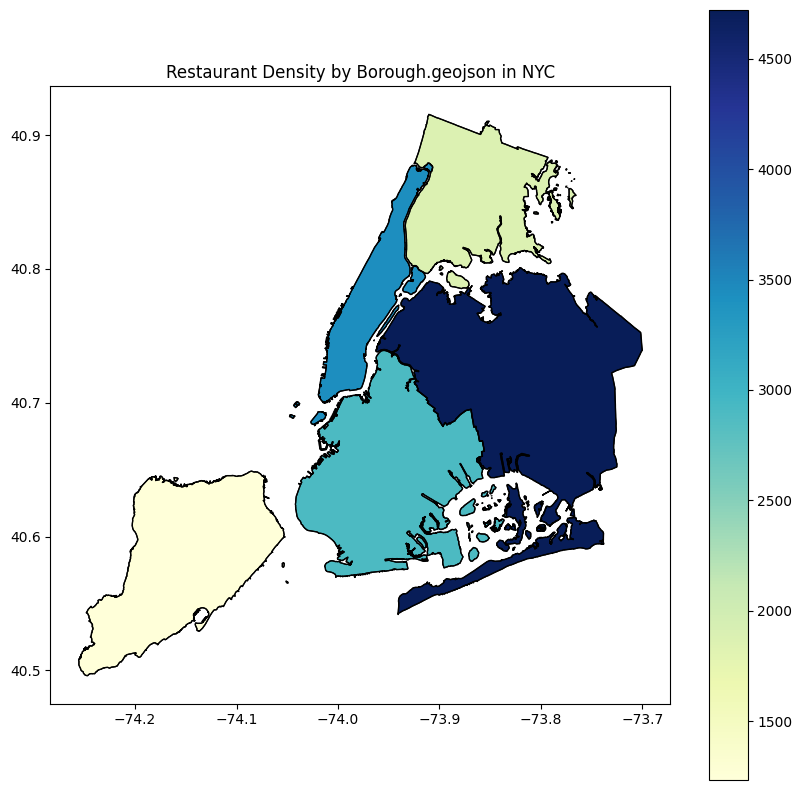

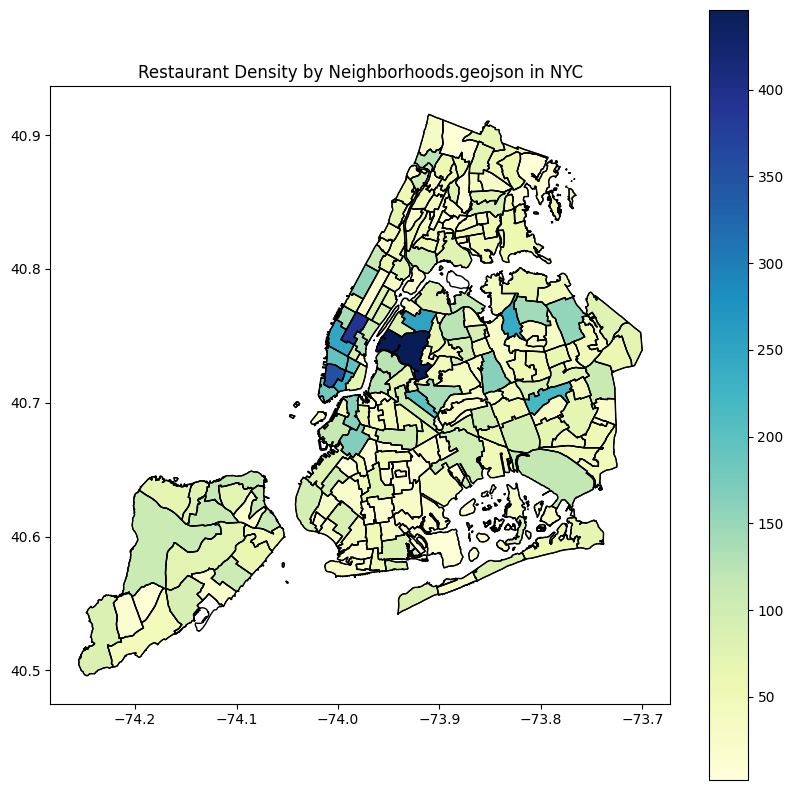

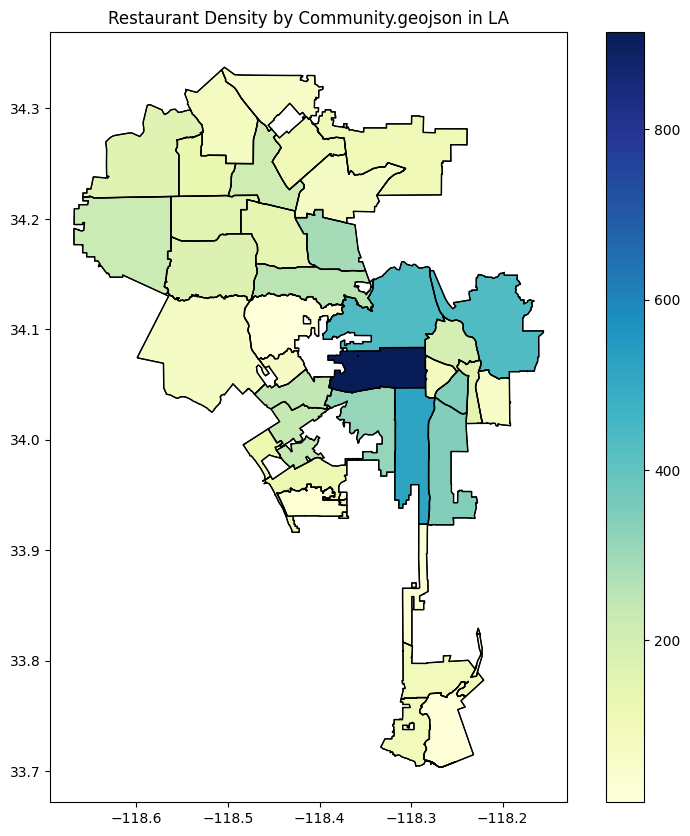

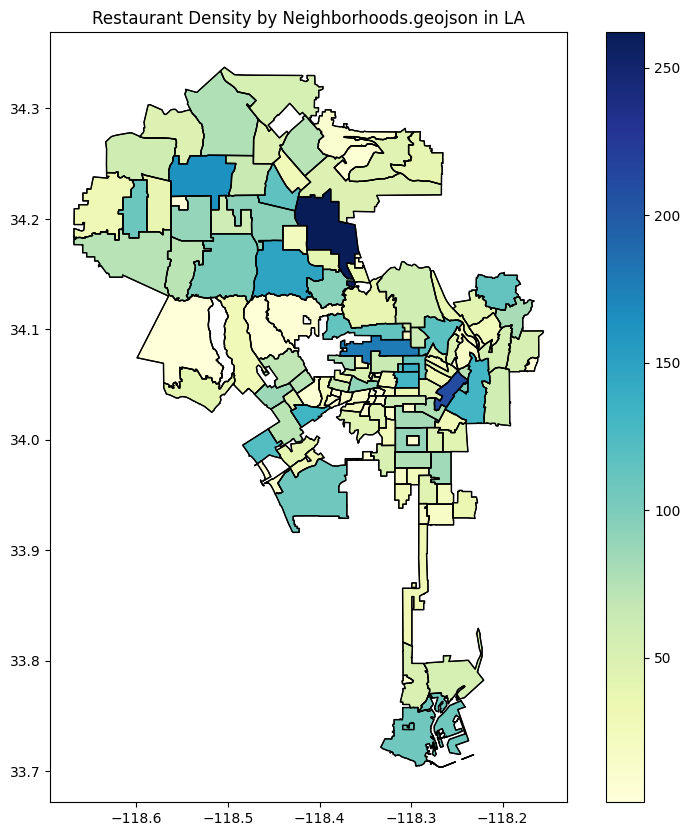

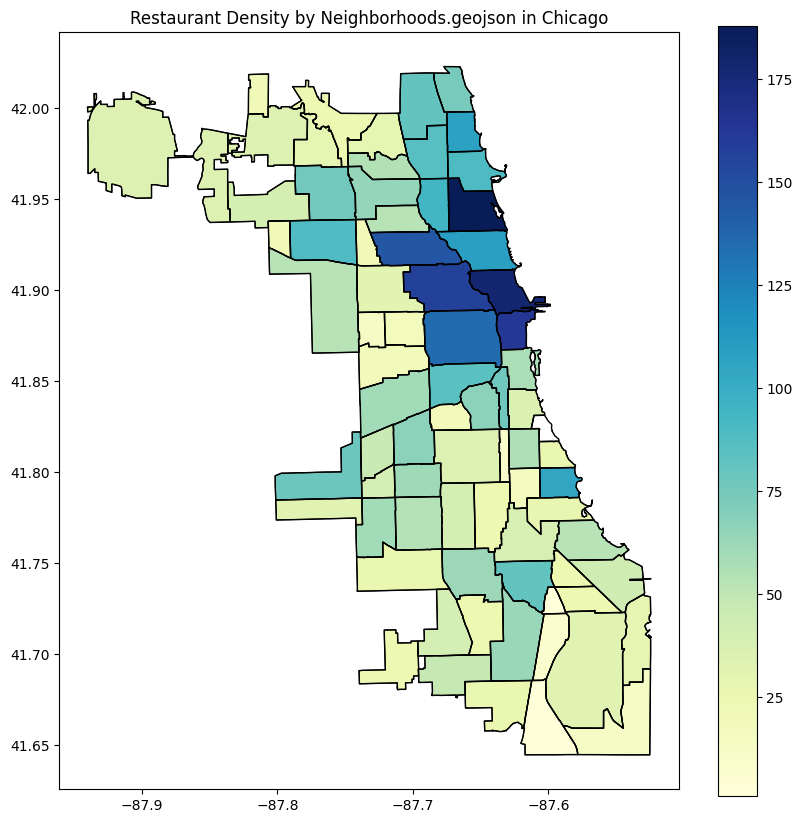

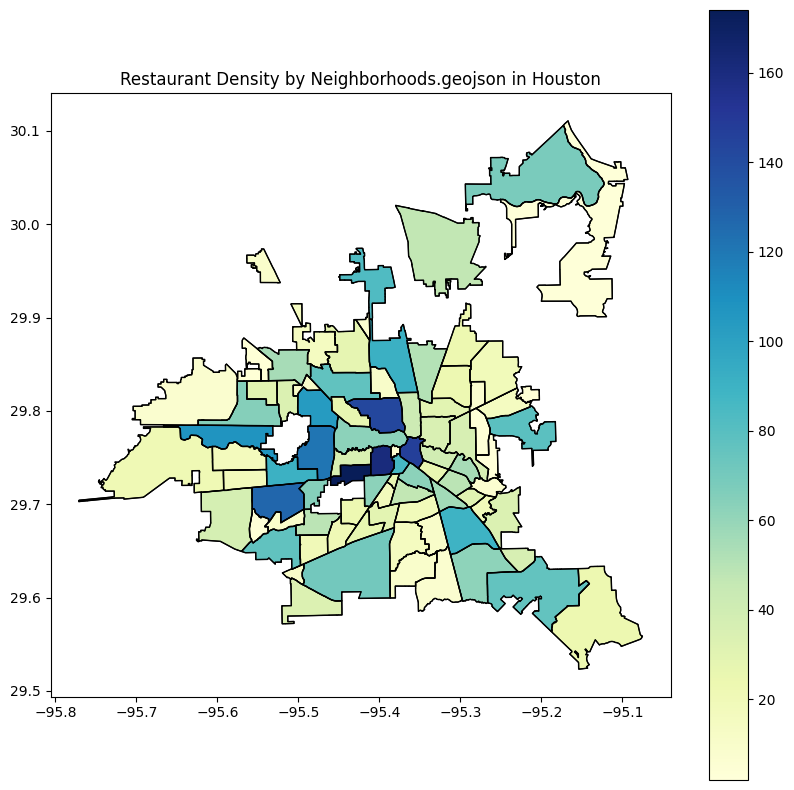

In [ ]:
neighborhood_restaurant_density(city_dataframes, boundaries)

## Price level

In [ ]:
# price_mapping = {'$': 1, '$$': 2, '$$$': 3, '$$$$': 4}
#     # Process each city file
# for city, file in city_files.items():
#       df = pd.read_csv(file)
#       df = df.drop(columns=['Unnamed: 0', 'id', 'image_url', 'is_closed', 'attributes'])

#         # Apply literal_eval to the 'categories' column
#       df = literal_eval_category(df)

#         # Extract titles from the 'categories' column
#       df['category_titles'] = df['categories'].apply(extract_titles)
#       df['price'] = df['price'].map(price_mapping)

#       city_data[city] = df

In [ ]:
def neighborhood_price(city_dataframes, boundaries):
  price_mapping = {'$': 1, '$$': 2, '$$$': 3, '$$$$': 4}
  for city, df in city_dataframes.items():
    df['price'] = df['price'].map(price_mapping)
    for item in boundaries[city]:
      neighborhoods = gpd.read_file(item)
      restaurants = df
      restaurants_gdf = gpd.GeoDataFrame(
          restaurants,
          geometry=gpd.points_from_xy(restaurants.longitude, restaurants.latitude),
          crs="EPSG:4326"
      )
      restaurants_in_neighborhoods = gpd.sjoin(restaurants_gdf, neighborhoods, how='left', predicate='within')
      neighborhood_scores = restaurants_in_neighborhoods.groupby('NBNAME').agg({
          'price': 'mean'
      }).reset_index()
      neighborhoods = neighborhoods.merge(neighborhood_scores, how='left', left_on='NBNAME', right_on='NBNAME')
      district = item.split('_')[1]
      fig, ax = plt.subplots(figsize=(10, 10))
      neighborhoods.boundary.plot(ax=ax, linewidth=1, color='black')
      # Generate a cubehelix colormap from seaborn
      sns.set_palette("Blues")
      neighborhoods.plot(column='price', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.', legend=True)

      plt.title(f'Average Price Level by {district} in {city}')
      plt.show()
      # return restaurants_in_neighborhoods

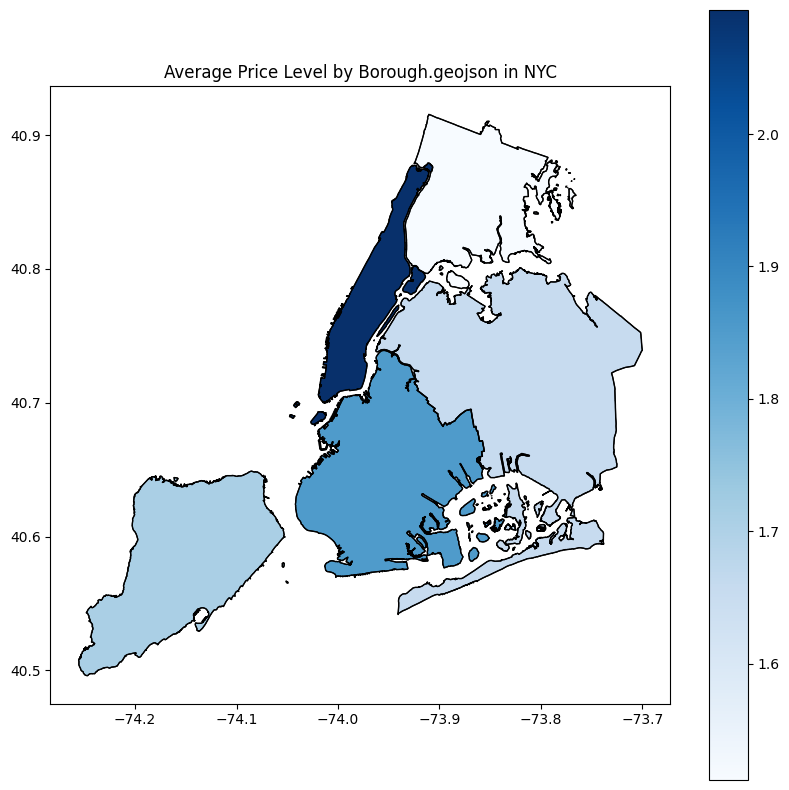

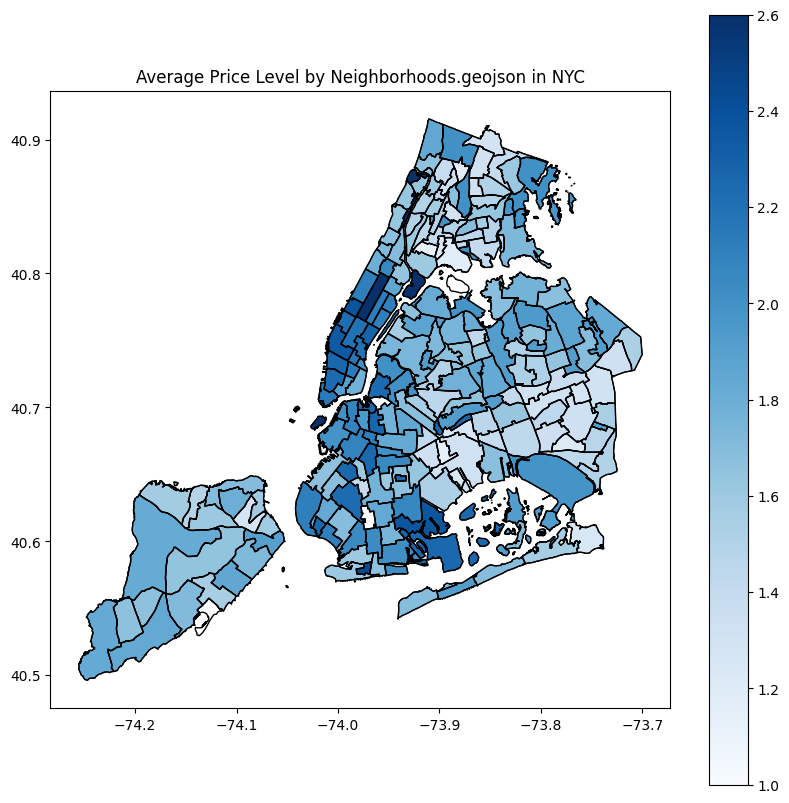

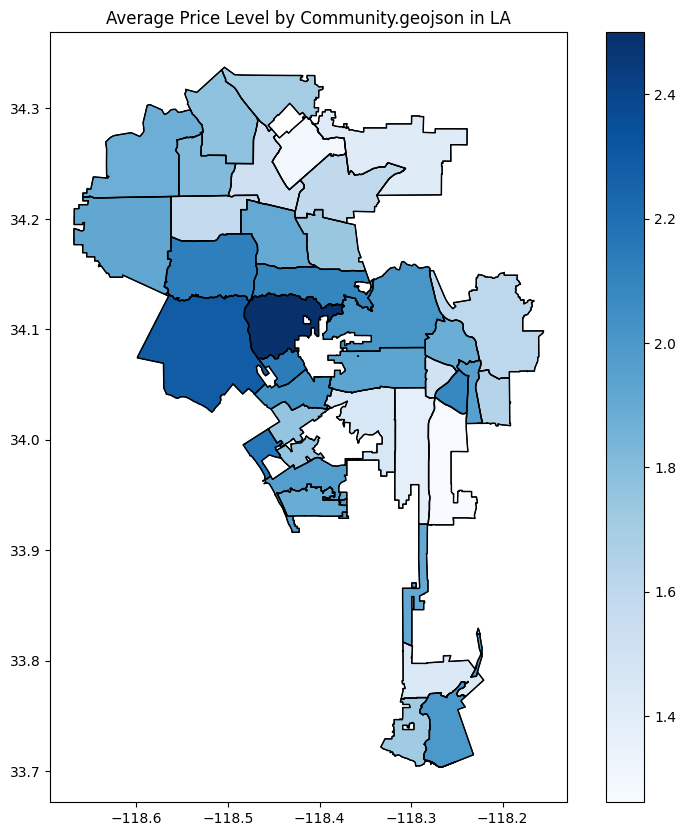

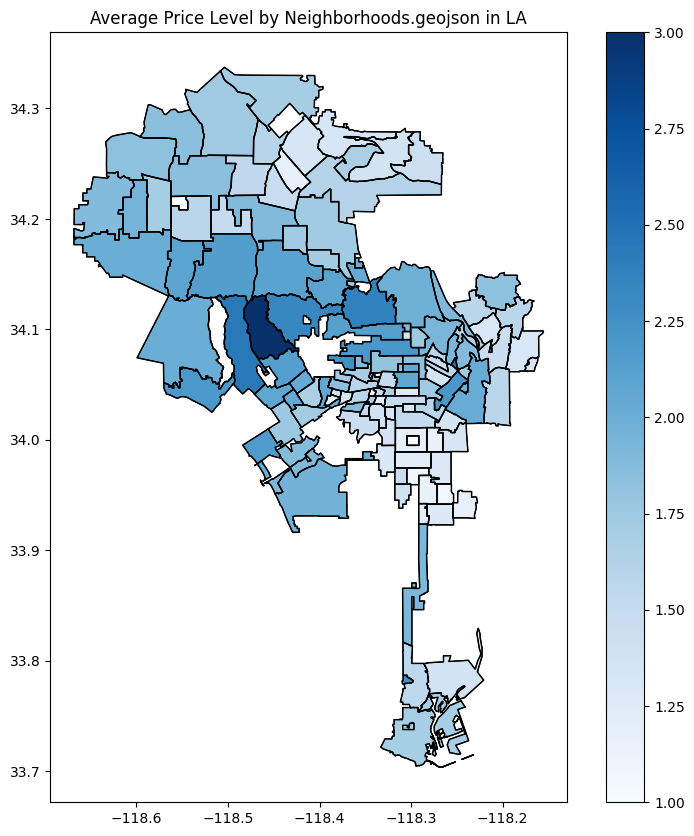

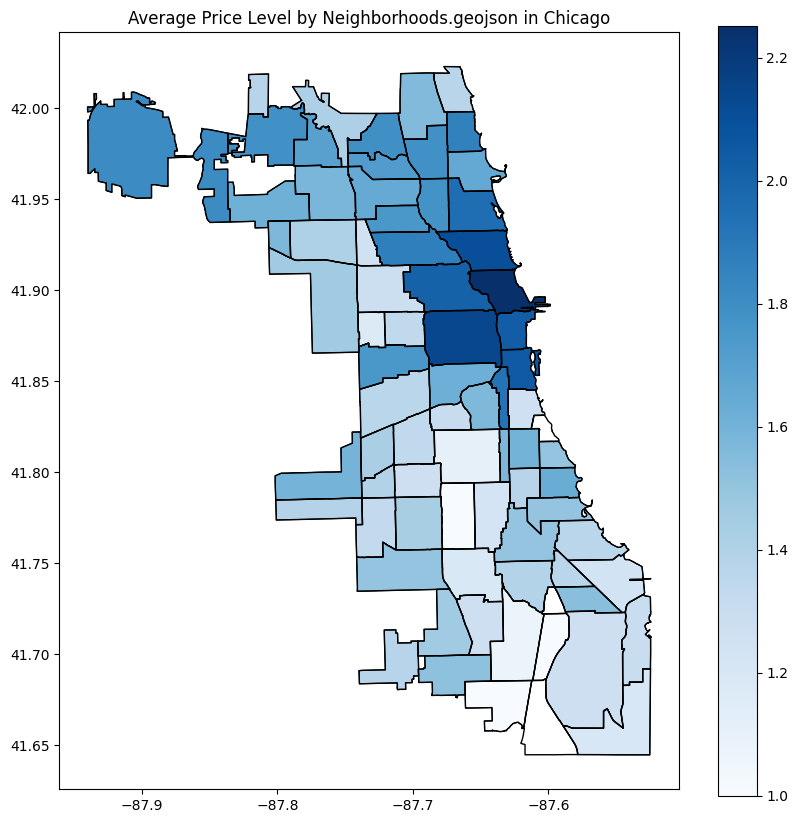

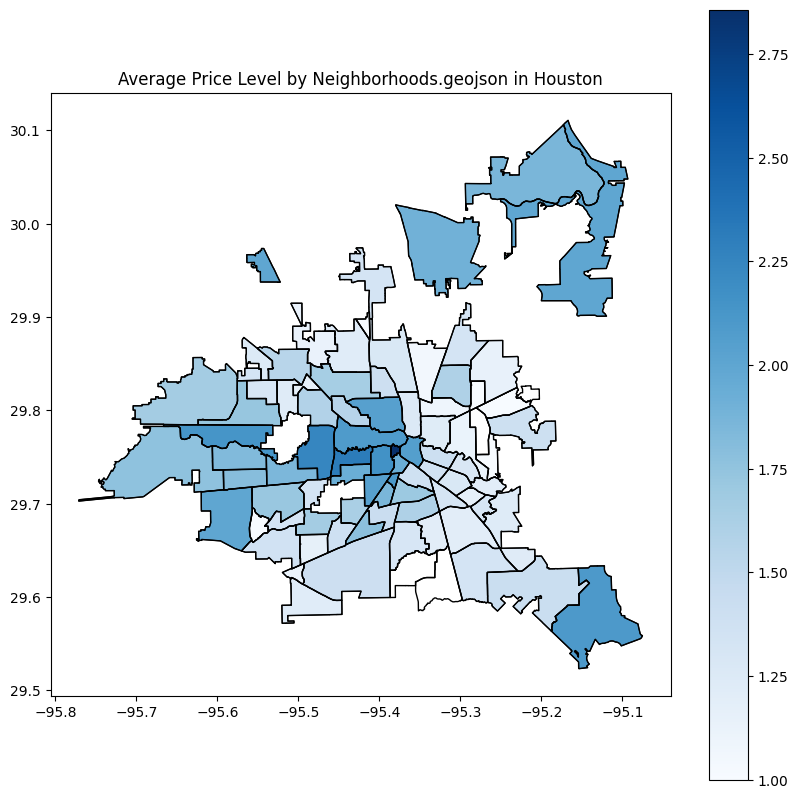

In [ ]:
neighborhood_price(city_dataframes, boundaries)